# Classifier Model Training
### Load processed data and train classifier models

### 1. Import libraries

In [36]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import re
import datetime
from tqdm import tqdm

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.preprocessing import scale

### 2. Load data

In [3]:
ticker_symbol = "RTX"
merged_substituted_labeled_df = pd.read_pickle(f"../data/processed/{ticker_symbol}_merged_substituted_labeled_df.pkl")

In [5]:
# Only keep relevant data, so drop all the other features
relevant_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Negative Score', 'Neutral Score', 'Positive Score', 'Compound Score', 'Price Change Label']
df = merged_substituted_labeled_df[relevant_columns]

In [15]:
df

,Open,High,Low,Close,Adj Close,Volume,Negative Score,Neutral Score,Positive Score,Compound Score,Price Change Label
Date,,,,,,,,,,,
2017-06-23,76.784142,77.054749,76.456894,76.916298,65.686562,6119398,0.000,0.566,0.434,0.3182,0
2017-06-26,77.035873,77.463814,76.658279,76.696037,65.498444,2613111,0.000,0.000,0.000,0.0000,0
2017-06-27,76.727501,76.865952,76.469475,76.519821,65.347954,2706226,0.000,0.000,0.000,0.0000,1
2017-06-28,76.821899,77.155441,76.582756,77.092514,65.837029,2862107,0.000,0.000,0.000,0.0000,0
2017-06-29,77.042168,77.067337,75.909378,76.557587,65.380203,3747815,0.000,0.000,0.000,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-14,82.180000,82.250000,80.610001,80.690002,80.099564,13128900,0.000,0.000,0.000,0.0000,0
2023-11-15,80.510002,81.250000,79.779999,80.629997,80.040001,10757800,0.007,0.879,0.114,0.9571,1
2023-11-16,80.470001,80.830002,79.930000,80.230003,80.230003,7578700,0.018,0.848,0.134,0.9887,0


### 3. Classifier Model Training

In [17]:
# Feature data set
X = df.drop('Price Change Label', axis=1)
X = np.array(X)

# Target data set
y = np.array(df['Price Change Label'])

In [25]:
X[:10]

array([[7.67841415e+01, 7.70547485e+01, 7.64568939e+01, 7.69162979e+01,
        6.56865616e+01, 6.11939800e+06, 0.00000000e+00, 5.66000000e-01,
        4.34000000e-01, 3.18200000e-01],
       [7.70358734e+01, 7.74638138e+01, 7.66582794e+01, 7.66960373e+01,
        6.54984436e+01, 2.61311100e+06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [7.67275009e+01, 7.68659515e+01, 7.64694748e+01, 7.65198212e+01,
        6.53479538e+01, 2.70622600e+06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [7.68218994e+01, 7.71554413e+01, 7.65827560e+01, 7.70925140e+01,
        6.58370285e+01, 2.86210700e+06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [7.70421677e+01, 7.70673370e+01, 7.59093781e+01, 7.65575867e+01,
        6.53802032e+01, 3.74781500e+06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [7.67841415e+01, 7.71806183e+01, 7.65387039e+01, 7.68470764e+01,
   

In [26]:
y[:10]

array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype=int64)

In [28]:
# We need to split the data into train and test sets, but you can't split time series data randomly due to look-ahead, so we will split first 75% and last 25%
split = int(0.75 * len(df))

X_train = X[0:split]
y_train = y[0:split]

X_test = X[split:]
y_test = y[split:]

In [47]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(1210, 10)
(1210,)
(404, 10)
(404,)


In [37]:
# Let's try training one model
model = LinearDiscriminantAnalysis().fit(X_train, y_train)

In [38]:
# Model Predictions
predictions = model.predict(X_test)
predictions

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,

In [39]:
# Actual Values
y_test

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [40]:
# Model metrics 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.49      0.38      0.43       204
           1       0.49      0.59      0.53       200

    accuracy                           0.49       404
   macro avg       0.49      0.49      0.48       404
weighted avg       0.49      0.49      0.48       404



In [43]:
# Scale features

X_train = scale(X_train)
X_test = scale(X_test)

In [76]:
# Confusion matrix function

def plot_confusion_matrix(y_true, y_pred, labels=["Decreased", "Increased"], normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=labels, yticklabels=labels, title=title, ylabel='Actual', xlabel='Predicted')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    if normalize:
        fmt = '.2f'
    else:
        fmt = 'd'
    thresh = cm.max() / 1.2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="snow" if cm[i, j] > thresh else "black", size=20)
    ax.grid(False)
    fig.tight_layout()
    return ax


_____________________________* LinearDiscriminantAnalysis *_____________________________



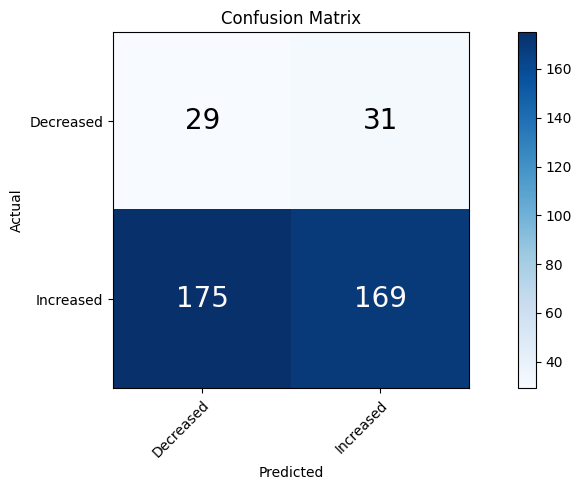

              precision    recall  f1-score   support

   Decreased       0.14      0.48      0.22        60
   Increased       0.84      0.49      0.62       344

    accuracy                           0.49       404
   macro avg       0.49      0.49      0.42       404
weighted avg       0.74      0.49      0.56       404


_____________________________* SGDClassifier *_____________________________



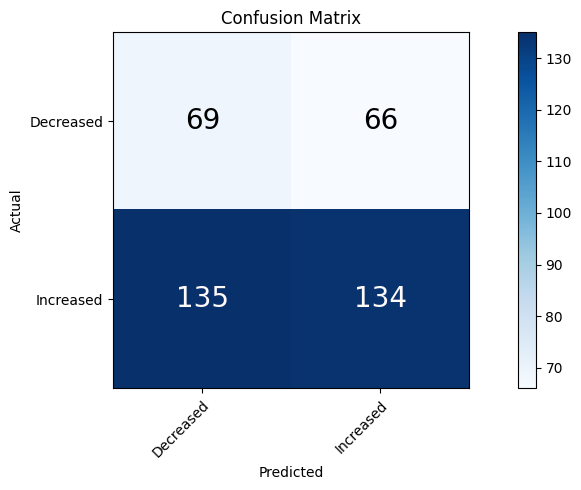

              precision    recall  f1-score   support

   Decreased       0.34      0.51      0.41       135
   Increased       0.67      0.50      0.57       269

    accuracy                           0.50       404
   macro avg       0.50      0.50      0.49       404
weighted avg       0.56      0.50      0.52       404


_____________________________* SVM Classification *_____________________________



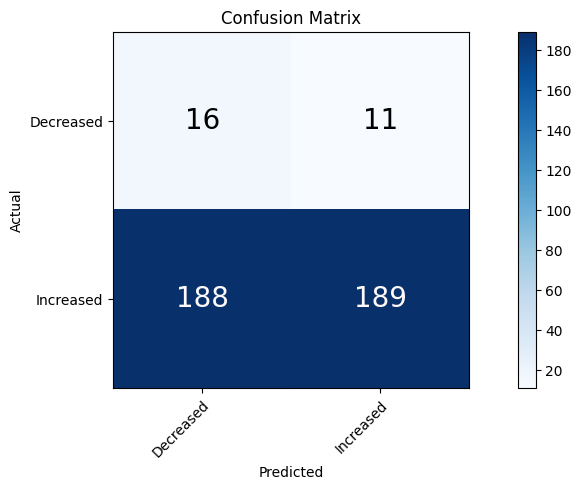

              precision    recall  f1-score   support

   Decreased       0.08      0.59      0.14        27
   Increased       0.94      0.50      0.66       377

    accuracy                           0.51       404
   macro avg       0.51      0.55      0.40       404
weighted avg       0.89      0.51      0.62       404


_____________________________* KNeighborsClassifier *_____________________________



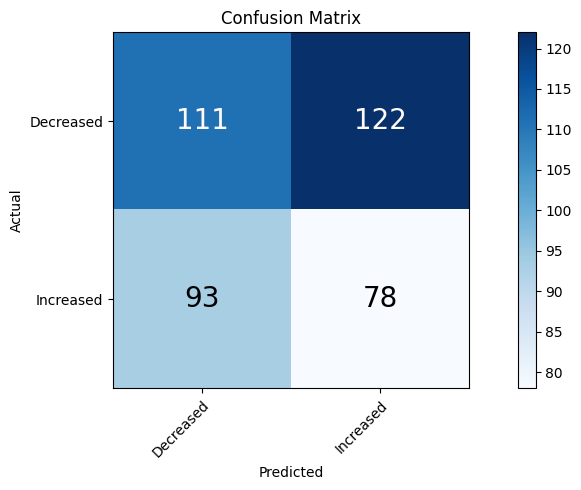

              precision    recall  f1-score   support

   Decreased       0.54      0.48      0.51       233
   Increased       0.39      0.46      0.42       171

    accuracy                           0.47       404
   macro avg       0.47      0.47      0.46       404
weighted avg       0.48      0.47      0.47       404


_____________________________* RandomForestClassifier *_____________________________



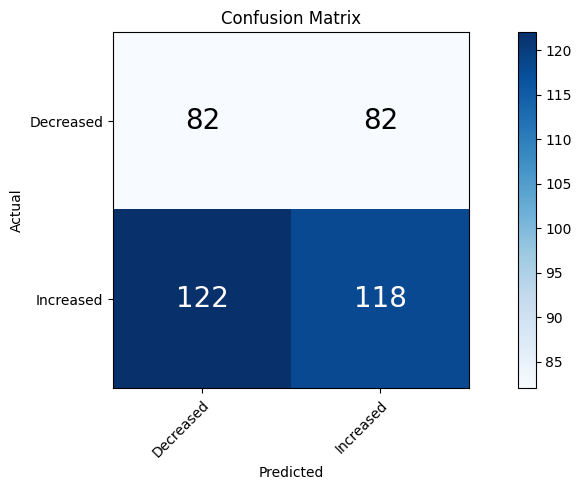

              precision    recall  f1-score   support

   Decreased       0.40      0.50      0.45       164
   Increased       0.59      0.49      0.54       240

    accuracy                           0.50       404
   macro avg       0.50      0.50      0.49       404
weighted avg       0.51      0.50      0.50       404


_____________________________* GaussianProcessClassifier *_____________________________



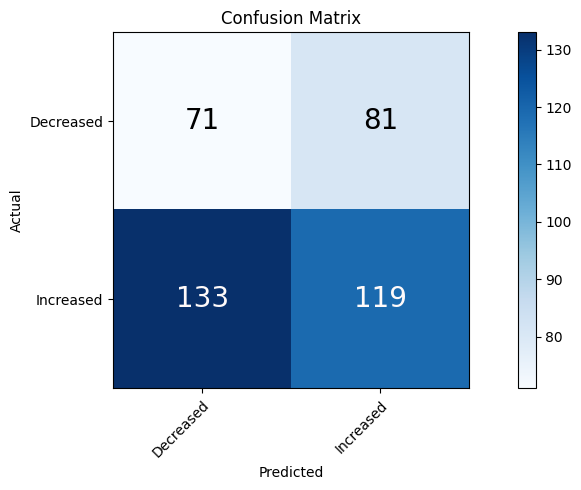

              precision    recall  f1-score   support

   Decreased       0.35      0.47      0.40       152
   Increased       0.59      0.47      0.53       252

    accuracy                           0.47       404
   macro avg       0.47      0.47      0.46       404
weighted avg       0.50      0.47      0.48       404



In [79]:
# Now let's test several models

models = {'LinearDiscriminantAnalysis':LinearDiscriminantAnalysis(),
          'SGDClassifier': SGDClassifier(loss="hinge", penalty="l2", max_iter=120),
          'SVM Classification': SVC(),
          'KNeighborsClassifier':KNeighborsClassifier(n_neighbors=8),
          'RandomForestClassifier': RandomForestClassifier(n_estimators=120),
          'GaussianProcessClassifier': GaussianProcessClassifier()
         }

for model_name in models.keys():
    model = models[model_name]
    print('\n_____________________________*',model_name,'*_____________________________\n')
    model.fit(X_train,y_train)
    plot_confusion_matrix(model.predict(X_test),y_test, title="Confusion Matrix")
    np.set_printoptions(precision=1)
    plt.show()
    print(classification_report(model.predict(X_test),y_test, target_names=['Decreased', 'Increased']))